# 04. Differential Photometry

Here I will demonstrate differential photometry for single-filter observation, which we have from KMTNet.

From note 3, we learnt how to query sidereal objects and the asteroid. Here, I will show how to perform aperture photometry to the given field.

## 1. Importing and Setting Up

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, ccdproc, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2019-04-30 23:05:46 (KST = GMT+0900) 
0 Python     3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    6.5.0
2 OS         Darwin 18.5.0 x86_64 i386 64bit
3 astropy    3.1.2
4 numpy      1.16.2
5 scipy      1.2.1
6 matplotlib 3.0.3
7 astroquery 0.3.9
8 ccdproc    1.3.0.post1
9 photutils  0.6
10 version_information 1.0.3


In [6]:
from pathlib import Path
import numpy as np

from astropy.io import fits
from astropy import units as u
from astropy.time import Time
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.stats import sigma_clipped_stats

from astroquery.vizier import Vizier
from astroquery.jplhorizons import Horizons

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.detection import DAOStarFinder

from matplotlib import pyplot as plt
from matplotlib import rcParams

import warnings
warnings.filterwarnings('ignore', append=True, category=UserWarning)

from matplotlib import pyplot as plt

def znorm(image):
    return ImageNormalize(image, interval=ZScaleInterval())


def zimshow(ax, image, **kwargs):
    return ax.imshow(image, norm=znorm(image), origin='lower', **kwargs)


def panstarrs_query(ra_deg, dec_deg, rad_deg, columns=None, column_filters={},
                    maxsources=10000):
    """
    Query PanSTARRS @ VizieR using astroquery.vizier
    :param ra_deg: RA in degrees
    :param dec_deg: Declination in degrees
    :param rad_deg: field radius in degrees
    :param maxmag: upper limit G magnitude (optional)
    :param maxsources: maximum number of sources
    :return: astropy.table object
    Note
    ----
    All columns: http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=II/349
    """
    if columns is None:
        columns = ['objID', 'RAJ2000', 'DEJ2000', 'e_RAJ2000', 'e_DEJ2000',
                   'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 
                   'zmag', 'e_zmag', 'ymag', 'e_ymag']
    vquery = Vizier(columns=columns,
                    column_filters=column_filters,
                    row_limit=maxsources)

    field = SkyCoord(ra=ra_deg, dec=dec_deg,
                     unit=(u.deg, u.deg),
                     frame='icrs')
    return vquery.query_region(field,
                               width=("{}d".format(rad_deg)),
                               catalog="II/349/ps1")[0]


# Remove the next one line if you are not using Notebook (ipynb)
%matplotlib inline

plt.style.use('default')
rcParams.update({'font.size':12})

DATAPATH = Path('..') / 'data'

## 2. Load Data and Query

For details, please refer to note 03.

In [7]:
allfits = list(DATAPATH.glob("*.fits"))
allfits.sort()

hdul = fits.open(allfits[0])
hdr = hdul[0].header
data = hdul[0].data

# Set WCS and print for your information
w = WCS(hdr)

# Query object
objname = "4179"
observat = "B31"
t_obs = Time(hdr["DATE-OBS"]) + hdr["EXPTIME"] * u.s / 2
obj = Horizons(id=objname, location=observat, epochs=t_obs.jd)
obj_q = obj.ephemerides()

pos_sky = SkyCoord(obj_q["RA"][0], obj_q["DEC"][0], unit='deg')
pos_pix = pos_sky.to_pixel(wcs=w)

# Query sidereal objects (PS1)
image_center = np.array(hdul[0].shape) / 2 - 0.5
cent_coord = w.wcs_pix2world(image_center[0], image_center[1], 0)
# 0 means that we are using 0-indexing. You may use 1 for 1-indexing.

result = panstarrs_query(cent_coord[0], cent_coord[1], rad_deg=0.1,
                        column_filters={"gmag":"13.0..20.0", "e_gmag":"<0.10"})
pos_stars = SkyCoord(result["RAJ2000"], result["DEJ2000"], unit='deg')
pos_stars = pos_stars.to_pixel(wcs=w)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


## 3. Star Matching

There are two ways to match the star you queried above with the object visible in the image.
1. _Educational purpose_: I will show you how you can find **star-like** objects in the image automatically. Then I will show you how these "found star-like objects" match with the queired objects.
2. _Simplest and actually the preferred way_: Use the X Y coordinates from ``pos_stars`` above. Use it as the initial guess, and do centroiding at each position in the image.

### 3-1. Star Finder

There is ``photutils`` documentation on [detecting objects](https://photutils.readthedocs.io/en/stable/detection.html). Here I will use the [``DAOStarFinder`` module](https://photutils.readthedocs.io/en/stable/api/photutils.DAOStarFinder.html#photutils.DAOStarFinder), which is an implementation of the algorithm first developed by P. Stetson, and used extensively for the last 30-40 years by professional astronomers.

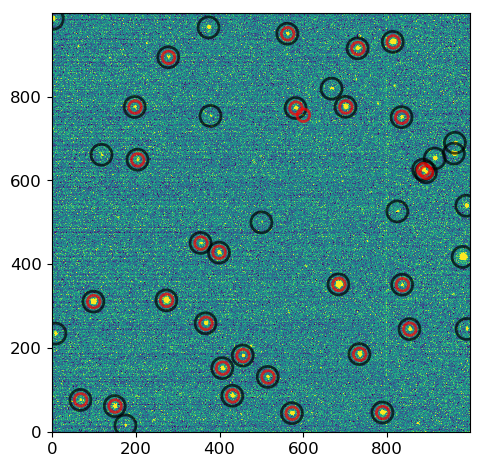

In [37]:
avg, med, std = sigma_clipped_stats(data) # default is 3-sigma, 5 iters
thresh = 5 * std
finder = DAOStarFinder(fwhm=4, threshold=thresh,   # In reality, FWHM must be measured a priori using, e.g., ``ginga``
                       sharplo=0.2, sharphi=1.0,   # default values 0.2 and 1.0
                       roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
                       sigma_radius=1.5,           # default values 1.5
                       ratio=1.0,                  # 1.0: circular gaussian
                       exclude_border=True)        # To exclude sources near edges

# The DAOStarFinder object ``finder`` gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
found = finder(data)

# Use ``found`` for aperture photometry:
coords_SF = (found['xcentroid'], found['ycentroid'])
apertures_SF = CAp(coords_SF, r=25)  

# For visualization, make fake apertures to the queried objects
apertures_PS1 = CAp(pos_stars, r=15)

# Plot all
fig, axs = plt.subplots(1, 1, figsize=(5, 6), sharex=False, sharey=False, gridspec_kw=None)
zimshow(axs, data)
apertures_SF.plot(color='k', lw=2, alpha=0.7)
apertures_PS1.plot(color='red', lw=2, alpha=0.7)
plt.tight_layout()

* **HOMEWORK**: Change ``roundlo=-1.0, roundhi=1.0``, to ``roundlo=-.5, roundhi=.5``, then see our object, at the center of image, is not detected from star finder. This happens since the observation was made in non-sidereal tracking mode, i.e., the moving object (our asteroid) become slightly elliptical on the CCD (i.e., its ``round`` parameter gets larger).

### 3-2. Centroiding

Now forget about the star finding algorithm, which is useful for star cluster photometry (when not all the stars of interest are in the catalog), but not useful in our case.

For each object of ``pos_stars``, we will do centroiding to find the exact position (center) of each star.

* I will arbitrarily set aperture radius to 1.5 FWHM $ \sim 1.5 \times 4 = 6$ pixels, and the inner and outer radii of annuli to be 4 and 6 FWHM, which are 16 and 24 pixels, respectively.
* **TIP**: There are stars which are close to each other. These stars should not be used. 
